In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# File Processing Functions
# -------------------------------

def get_numeric_id(filename):
    # Extract a numeric identifier from filenames matching the pattern "-<number>.log"
    match = re.search(r'-(\d+)\.log$', filename)
    if match:
        return int(match.group(1))
    return None 

def extract_accuracies_energies(file_path):
    # Extract epochs, energies, and accuracies from a log file
    accuracies = []
    energies = []  # Not used for now, but kept for future extensions
    
    # Read through the log file line by line
    with open(file_path, 'r') as file:
        for line in file:
            if "Final accuracies: " in line:
                # Find the part after the colon and parse the numbers in brackets
                accuracies = list(map(float, line.split(':')[-1].strip().strip('[]').split(',')))
    
    # Convert to percentage if values are between 0 and 1 (like 0.85 -> 85%)
    if accuracies and max(accuracies) <= 1:
        accuracies = [a * 100 for a in accuracies]
    
    # Create epoch numbers starting from 1
    epochs = list(range(1, len(accuracies) + 1))
    return epochs, energies, accuracies

def calculate_convergence(file_path, threshold, patience):
    # Determine the convergence epoch based on accuracy changes with given threshold and patience
    epochs, energies, accuracies = extract_accuracies_energies(file_path)
    consecutive_count = 0
    
    # Check each epoch to see if accuracy change is small enough
    for i in range(1, len(accuracies)):
        # Calculate the change from previous epoch
        if abs(accuracies[i] - accuracies[i - 1]) <= threshold:
            consecutive_count += 1
            # If we've seen enough consecutive small changes, we've converged
            if consecutive_count >= patience:
                return epochs[i], accuracies, energies
        else:
            # Reset counter if change is too big
            consecutive_count = 0
    
    # If no convergence found, return the last epoch
    return len(accuracies), accuracies, energies

def process_directory(directory, threshold, patience):
    # Process all log files in a directory and return convergence epochs and final accuracies
    results = []
    final_accuracies = []
    
    # Go through each log file in the directory
    for file_name in os.listdir(directory):
        if file_name.endswith(".log"):
            file_path = os.path.join(directory, file_name)
            conv_epoch, accuracies, _ = calculate_convergence(file_path, threshold, patience)
            results.append((file_name, conv_epoch))
            
            # Get the accuracy at the convergence point
            if conv_epoch is not None and conv_epoch <= len(accuracies):
                final_accuracies.append((file_name, accuracies[conv_epoch - 1]))  # -1 because list is 0-indexed
            else:
                final_accuracies.append((file_name, None))
    
    # Sort everything by the number in the filename (e.g., experiment-1.log, experiment-2.log, etc.)
    results.sort(key=lambda x: get_numeric_id(x[0]))
    final_accuracies.sort(key=lambda x: get_numeric_id(x[0]))
    
    # Convert to numpy arrays for easier handling
    convs = np.array([epoch for _, epoch in results])
    accs = np.array([acc for _, acc in final_accuracies])
    return convs, accs


In [2]:
def plot_two_boxplots_with_lines(arr1, arr2, title="", y_label="", dir=""):
    # Creates side-by-side boxplots with connecting lines between paired data points
    arr1 = np.array(arr1)
    arr2 = np.array(arr2)
    arr1.sort()
    arr2.sort()

    data = [arr1, arr2]
    fig, ax = plt.subplots(figsize=(6, 5))

    boxprops = dict(facecolor='lightgray', alpha=0.7)
    medianprops = dict(color='red', linewidth=2)
    whiskerprops = dict(color='black')
    capprops = dict(color='black')
    
    ax.boxplot(data,
               widths=0.5,
               patch_artist=True,
               boxprops=boxprops,
               medianprops=medianprops,
               whiskerprops=whiskerprops,
               capprops=capprops)

    ax.set_xticks([1, 2])
    ax.set_xticklabels(["Non-coupled model", "Coupled model"])

    jitter_width = 0.08  
    
    n_points = min(len(arr1), len(arr2))

    for i in range(n_points):
        x1 = 1 + np.random.uniform(-jitter_width, jitter_width)
        x2 = 2 + np.random.uniform(-jitter_width, jitter_width)

        y1 = arr1[i]
        y2 = arr2[i]

        ax.plot(x1, y1, 'o', color='blue')
        ax.plot(x2, y2, 'o', color='orange')

        ax.plot([x1, x2], [y1, y2], color='gray', alpha=0.5)

    ax.set_title(title)
    ax.set_ylabel(y_label)

    plt.tight_layout()

    os.makedirs(f"{dir}/eps", exist_ok=True)
    os.makedirs(f"{dir}/png", exist_ok=True)
    plt.show()
    fig.savefig(fname=f"{dir}/eps/box-{title}.eps",format='eps')
    fig.savefig(fname=f"{dir}/png/box-{title}.png",format='png')


In [3]:
import matplotlib.pyplot as plt
import numpy as np


def plot_plots(arr1, arr2, title, y_title, normalize=True, dir=""):
    # Calculate average values for both groups
    mean_convergence_c = np.mean(arr1)
    mean_convergence_nc = np.mean(arr2)
    print(mean_convergence_c)
    print(mean_convergence_nc)

    # Calculate standard error for error bars
    sem_convergence_c = np.std(arr1) / np.sqrt(len(arr1))
    sem_convergence_nc = np.std(arr2) / np.sqrt(len(arr2))

    # Find the higher value to use for normalization
    if mean_convergence_c > mean_convergence_nc:
        normalization_term = mean_convergence_c
    else:
        normalization_term = mean_convergence_nc

    # Scale everything to be between 0 and 1 if normalize is True
    if normalize:
        sem_convergence_c /= normalization_term
        sem_convergence_nc /= normalization_term

        mean_convergence_c /= normalization_term
        mean_convergence_nc /= normalization_term

        # Create the bar chart
        fig, ax1 = plt.subplots(figsize=(8, 6))
        categories = ['Non-Coupled Model', 'Coupled Model']
        mean_convergence = [mean_convergence_c, mean_convergence_nc]
        sem_convergence = [sem_convergence_c, sem_convergence_nc]

        # Make bars with error bars
        ax1.bar(categories, mean_convergence, yerr=sem_convergence, capsize=5, color=['skyblue', 'lightcoral'], alpha=0.8)
        ax1.set_title(f'{title}', fontsize=14)
        
        # Set y-axis label based on whether we normalized
        if normalize:
            ax1.set_ylabel(f'Normalized {y_title}', fontsize=12)
        
        # Add grid lines to make it easier to read
        ax1.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        
        # Save the plot in two formats
        fig.savefig(fname=f"{dir}/eps/mean-{title}.eps",format='eps')
        fig.savefig(fname=f"{dir}/png/mean-{title}.png",format='png')
        plt.show()

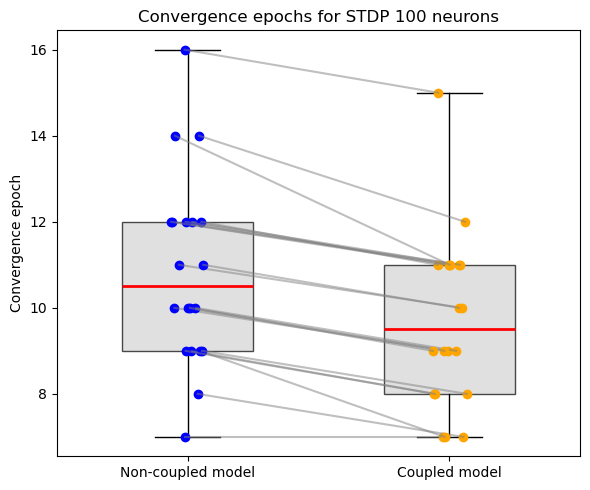

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


10.85
9.7


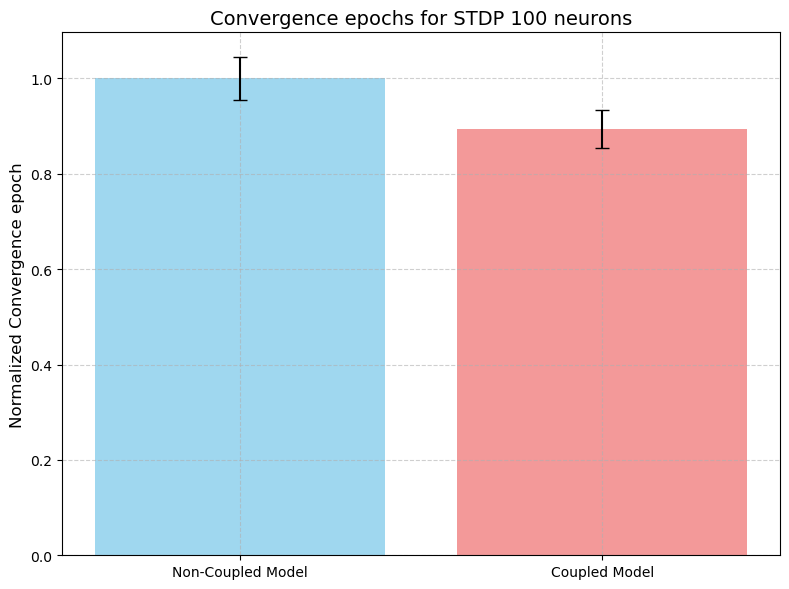

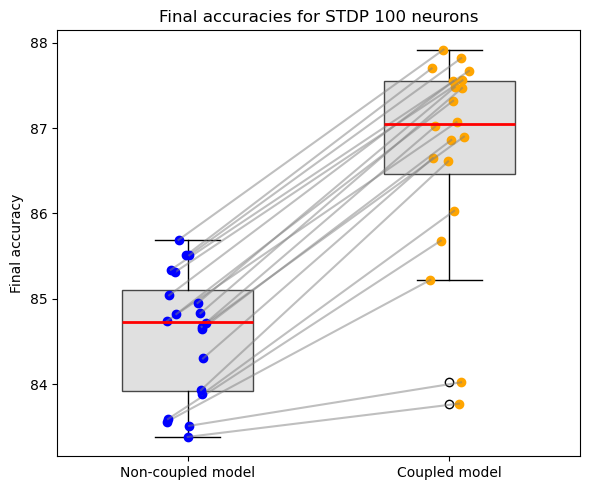

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


84.5965
86.716


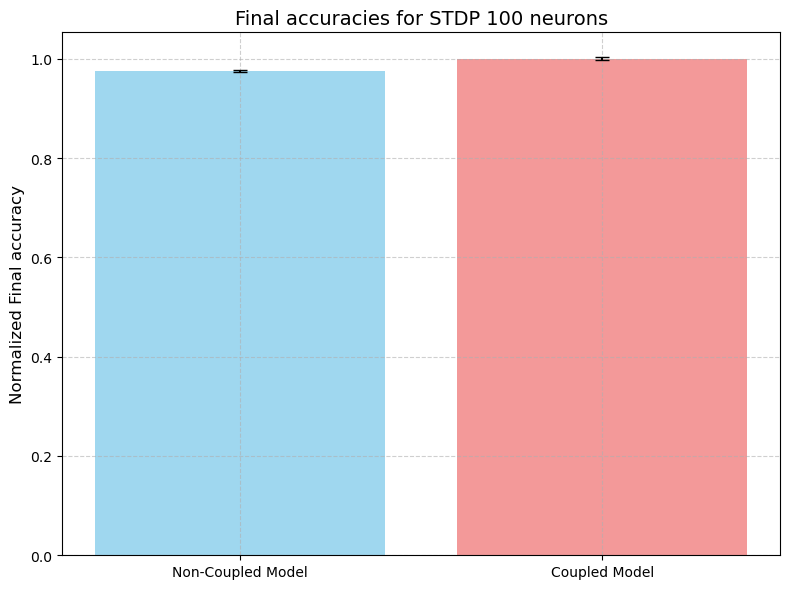

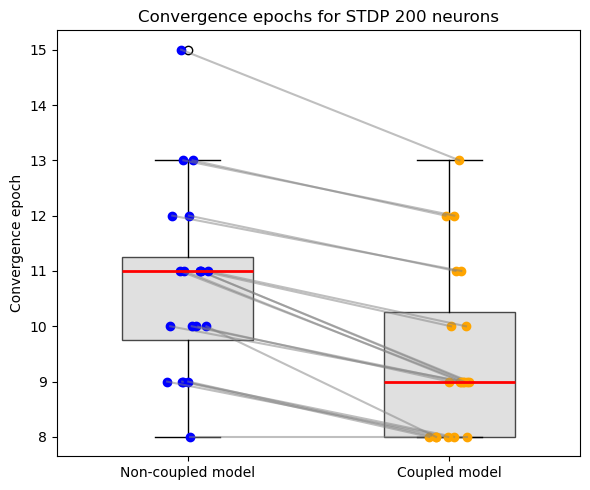

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


10.75
9.5


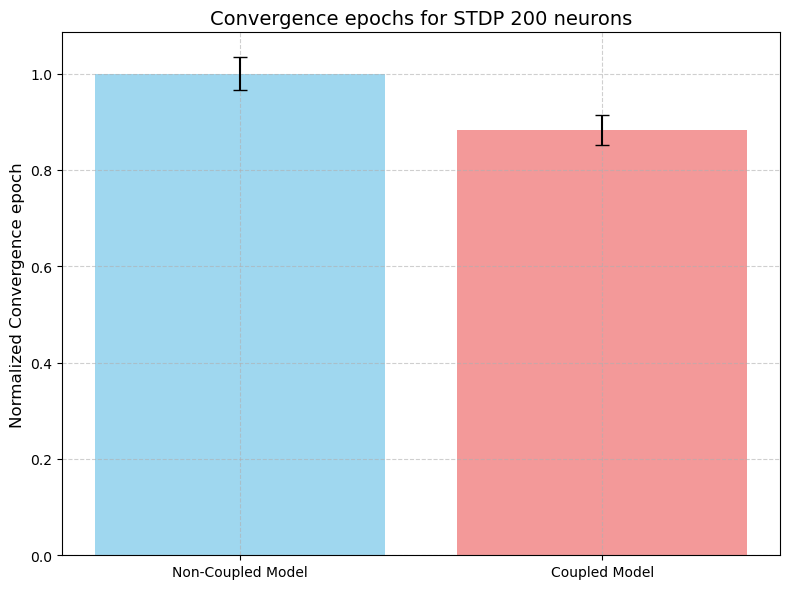

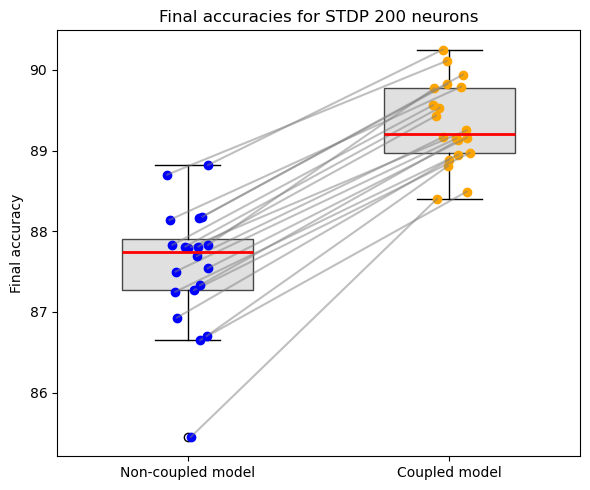

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


87.569
89.328


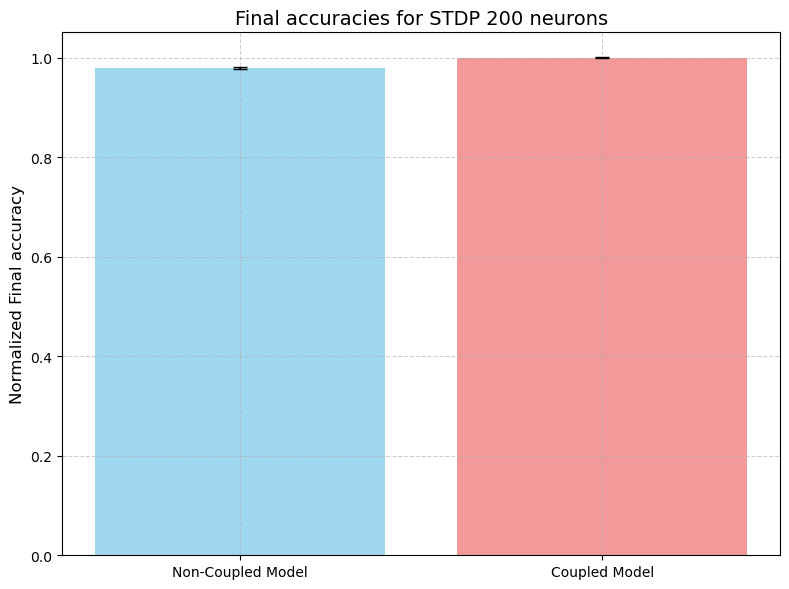

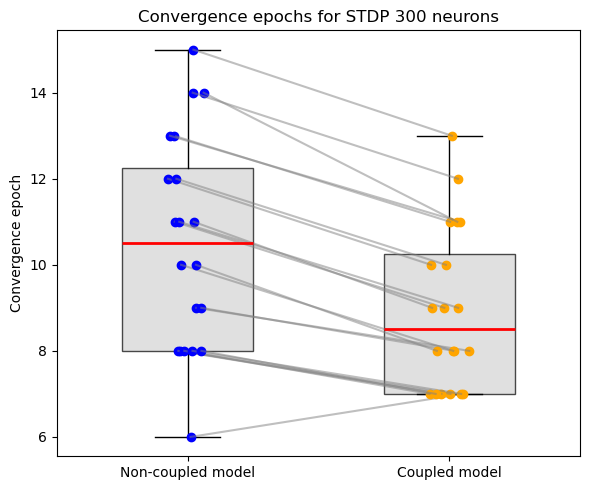

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


10.5
8.95


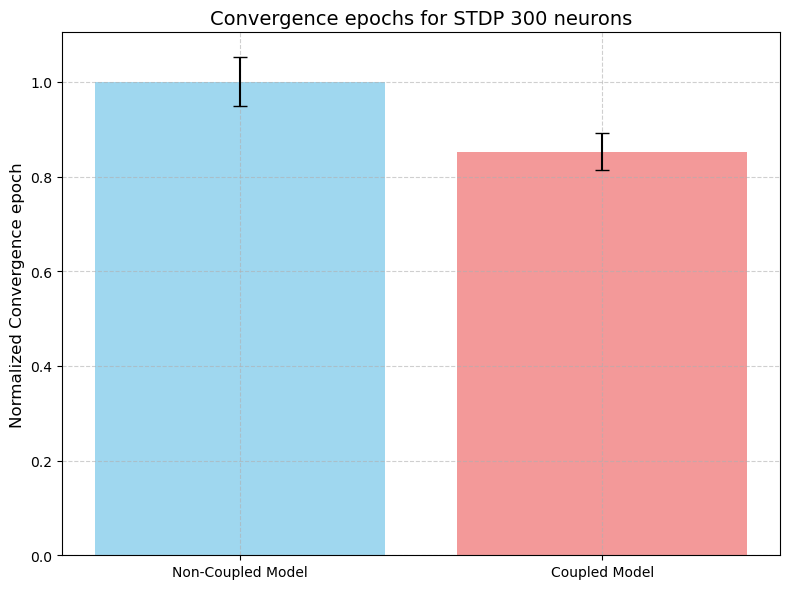

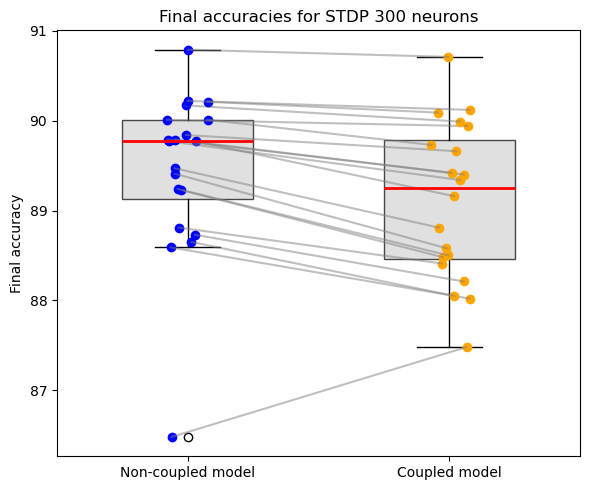

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


89.44899999999998
89.105


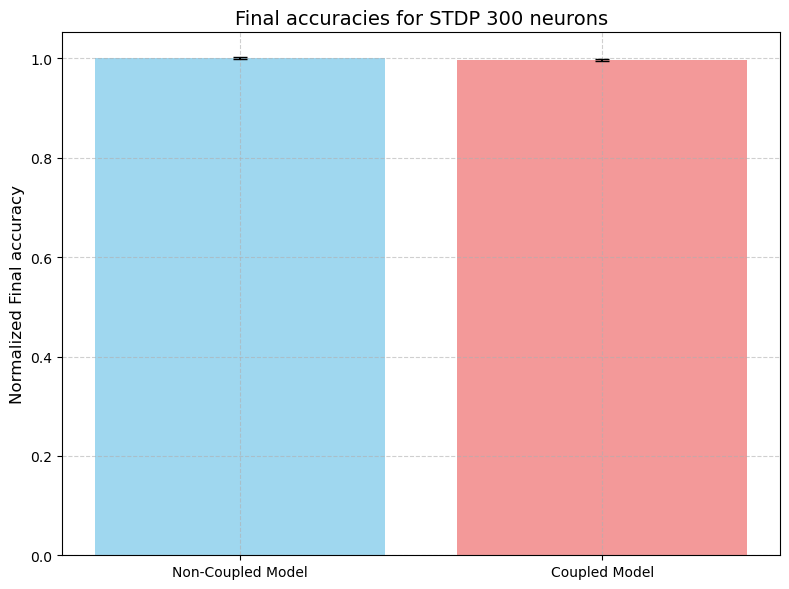

In [4]:
thresh_percent = 1
patience = 5    


# Process STDP logs.
stdp_sizes = ["100", "200", "300"]
mnist_data_dir = "data/mnist_stdp/"
mnist_plot_dir = "mnist-stdp-plots/"
# non-coupled for stdp is stored in data/mnist_stdp/size/false
# coupled for stdp is stored in data/mnist_stdp/size/true

# Process each size
for size in stdp_sizes:
    # Non-coupled
    non_coupled_dir = os.path.join(mnist_data_dir, size, "false")
    convs_nc, accs_nc = process_directory(non_coupled_dir, thresh_percent, patience)
    # Coupled
    coupled_dir = os.path.join(mnist_data_dir, size, "true")
    convs_c, accs_c = process_directory(coupled_dir, thresh_percent, patience)

    # Plot boxplots
    plot_two_boxplots_with_lines(convs_nc, convs_c,
                                 title=f"Convergence epochs for STDP {size} neurons",
                                 y_label="Convergence epoch",
                                 dir=mnist_plot_dir)

    plot_plots(convs_nc, convs_c,
               title=f"Convergence epochs for STDP {size} neurons",
               y_title="Convergence epoch",
               normalize=True,
               dir=mnist_plot_dir)
    plot_two_boxplots_with_lines(accs_nc, accs_c,
                                 title=f"Final accuracies for STDP {size} neurons",
                                 y_label="Final accuracy",
                                 dir=mnist_plot_dir)
    plot_plots(accs_nc, accs_c,
               title=f"Final accuracies for STDP {size} neurons",
               y_title="Final accuracy",
               normalize=True,
               dir=mnist_plot_dir)

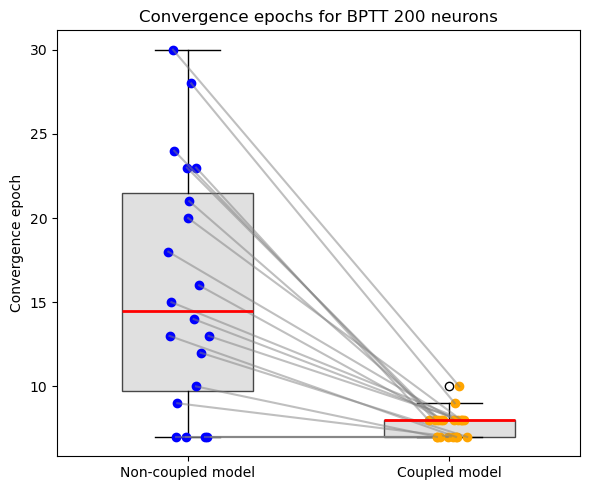

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


15.85
7.75


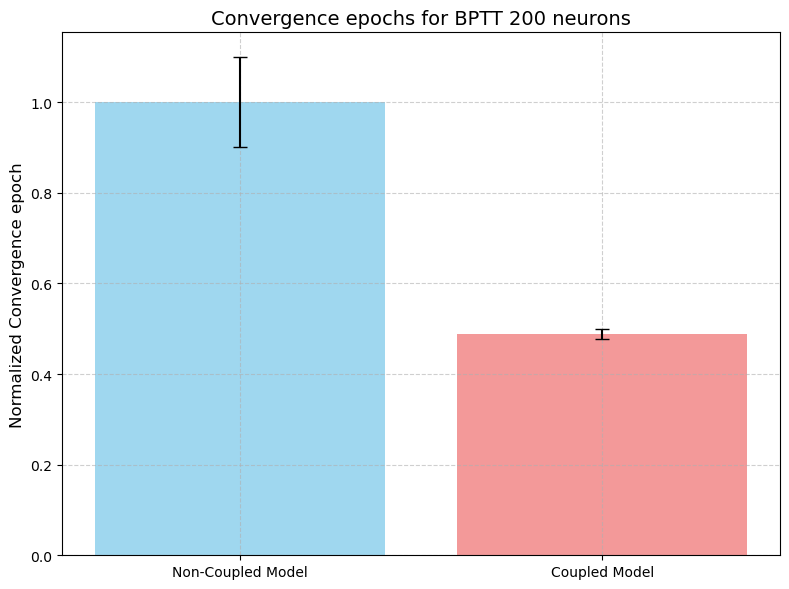

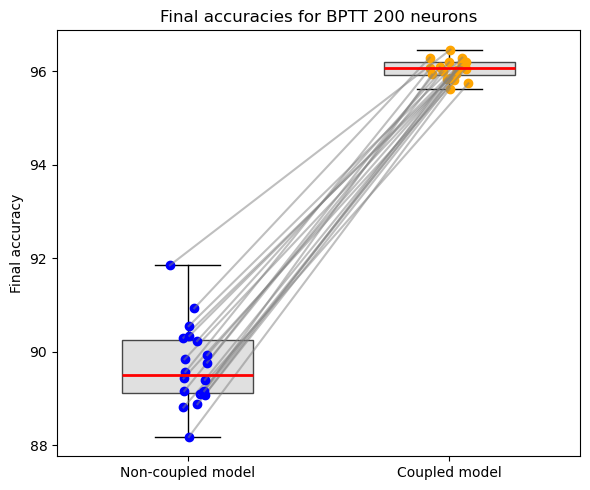

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


89.6815
96.04650000000001


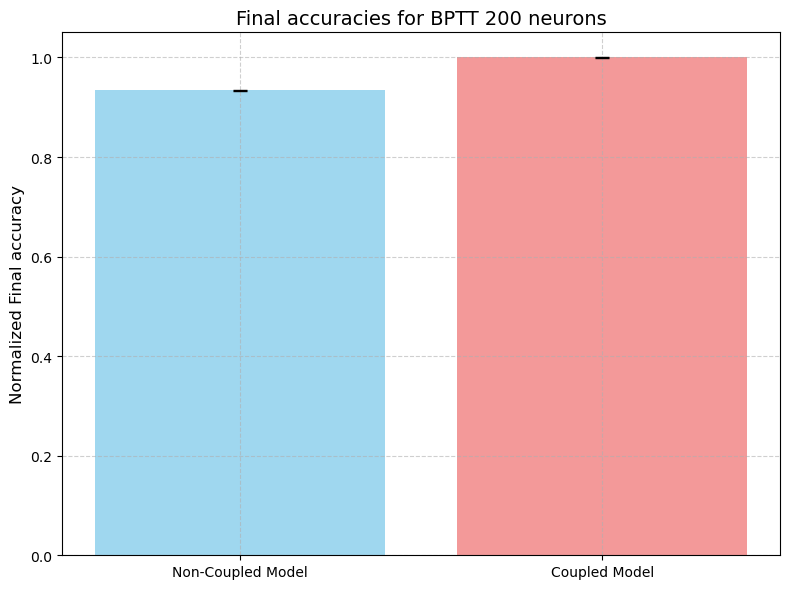

In [5]:
# plot bptt

bptt_sizes = ["200"]
bptt_data_dir = "data/mnist_bptt/"
bptt_plot_dir = "mnist-bptt-plots/"
# non-coupled for bptt is stored in data/mnist_bptt/size/false
# coupled for bptt is stored in data/mnist_bptt/size/true
# Process each size 
for size in bptt_sizes:
    # Non-coupled
    non_coupled_dir = os.path.join(bptt_data_dir, size, "false")
    convs_nc, accs_nc = process_directory(non_coupled_dir, thresh_percent, patience)
    # Coupled
    coupled_dir = os.path.join(bptt_data_dir, size, "true")
    convs_c, accs_c = process_directory(coupled_dir, thresh_percent, patience)

    # Plot boxplots
    plot_two_boxplots_with_lines(convs_nc, convs_c,
                                 title=f"Convergence epochs for BPTT {size} neurons",
                                 y_label="Convergence epoch",
                                 dir=bptt_plot_dir)

    plot_plots(convs_nc, convs_c,
               title=f"Convergence epochs for BPTT {size} neurons",
               y_title="Convergence epoch",
               normalize=True,
               dir=bptt_plot_dir)
    plot_two_boxplots_with_lines(accs_nc, accs_c,
                                 title=f"Final accuracies for BPTT {size} neurons",
                                 y_label="Final accuracy",
                                 dir=bptt_plot_dir)
    plot_plots(accs_nc, accs_c,
               title=f"Final accuracies for BPTT {size} neurons",
               y_title="Final accuracy",
               normalize=True,
               dir=bptt_plot_dir)

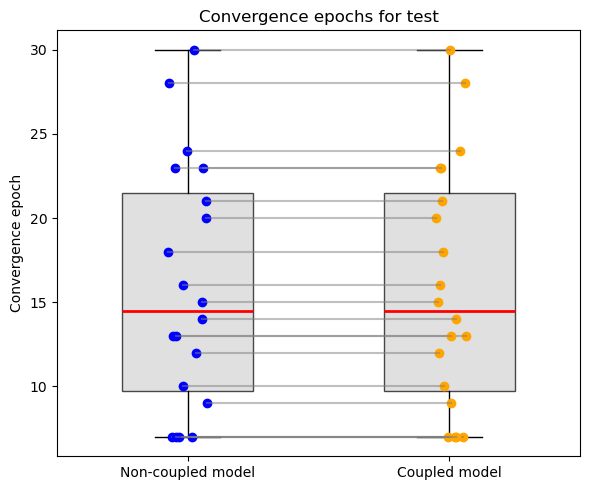

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


15.85
15.85


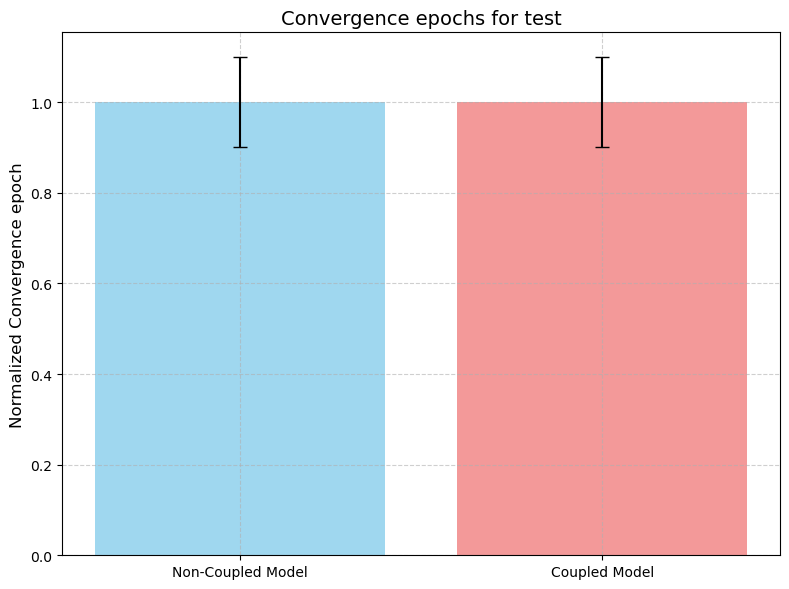

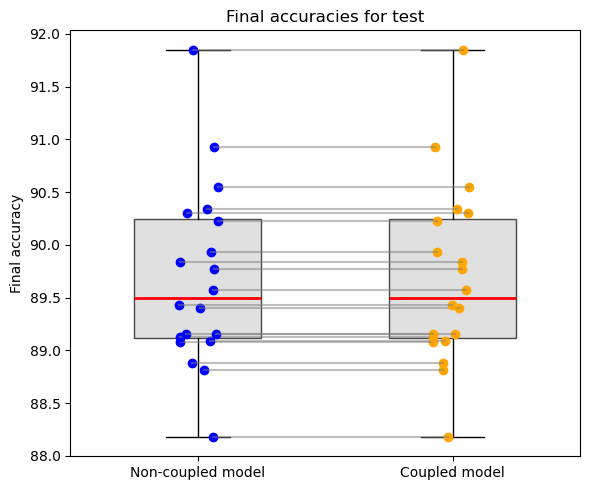

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


89.6815
89.6815


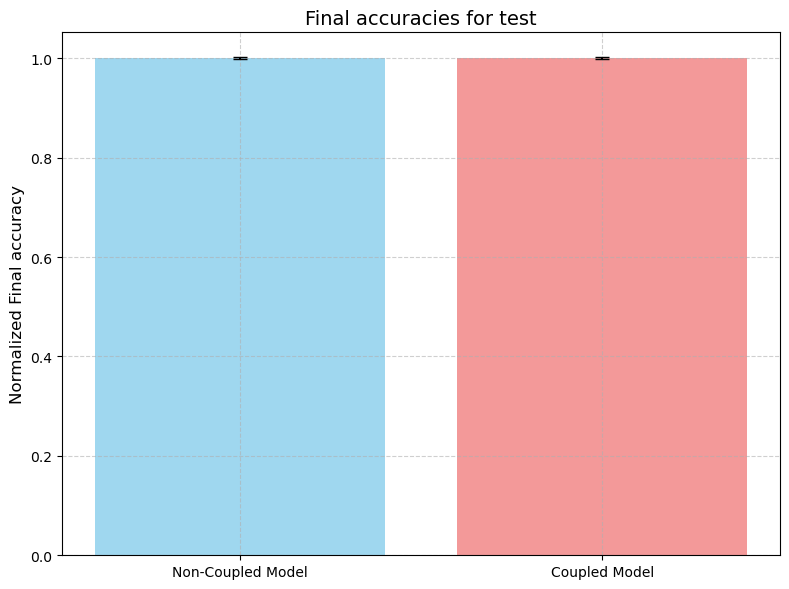

In [6]:
# Test code to make sure that matching of seeds works
test_direc = "data/match_test/"
test_plot_dir = "match-test-plots/"
non_coupled_dir = os.path.join(test_direc, "false")
convs_nc, accs_nc = process_directory(non_coupled_dir, thresh_percent, patience)
coupled_dir = os.path.join(test_direc, "true")
convs_c, accs_c = process_directory(coupled_dir, thresh_percent, patience)
# Plot boxplots
plot_two_boxplots_with_lines(convs_nc, convs_c,
                             title=f"Convergence epochs for test",
                             y_label="Convergence epoch",
                             dir=test_plot_dir)
plot_plots(convs_nc, convs_c,
           title=f"Convergence epochs for test",
           y_title="Convergence epoch",
           normalize=True,
           dir=test_plot_dir)
plot_two_boxplots_with_lines(accs_nc, accs_c,
                             title=f"Final accuracies for test",
                             y_label="Final accuracy",
                             dir=test_plot_dir)
plot_plots(accs_nc, accs_c,
           title=f"Final accuracies for test",
           y_title="Final accuracy",
           normalize=True,
           dir=test_plot_dir)

In [7]:
import pandas as pd
from scipy.stats import wilcoxon
def create_wilcoxon_results_table():
    """
    Creates a table with Wilcoxon signed-rank test results for convergence epochs
    and final accuracies for both STDP and BPTT models across different hidden sizes.
    """
    thresh_percent = 1
    patience = 5

    data_types = ["STDP", "BPTT"]
    results_data = []

    for data_type in data_types:
        if data_type == "STDP":
            sizes = ["100", "200", "300"]
            data_dir_base = "data/mnist_stdp/"
        else:  # BPTT
            sizes = ["200"]  
            data_dir_base = "data/mnist_bptt/"

        for size in sizes:
            non_coupled_dir = os.path.join(data_dir_base, size, "false")
            coupled_dir = os.path.join(data_dir_base, size, "true")


            convs_nc, accs_nc = process_directory(non_coupled_dir, thresh_percent, patience)
            convs_c, accs_c = process_directory(coupled_dir, thresh_percent, patience)

            # --- Convergence Epochs Test ---
            min_len_conv = 0
            if len(convs_nc) > 0 and len(convs_c) > 0:
                min_len_conv = min(len(convs_nc), len(convs_c))
                conv_stat, conv_p = wilcoxon(convs_nc[:min_len_conv], convs_c[:min_len_conv])
            results_data.append([data_type, size, "Convergence Epochs", conv_stat, conv_p])

            # --- Final Accuracies Test ---
            min_len_acc = 0
            if len(accs_nc) > 0 and len(accs_c) > 0:
                min_len_acc = min(len(accs_nc), len(accs_c))
                acc_stat, acc_p = wilcoxon(accs_nc[:min_len_acc], accs_c[:min_len_acc])
            results_data.append([data_type, size, "Final Accuracies", acc_stat, acc_p])

            # Print lengths for debugging
            if min_len_conv > 0:
                print(f"  {data_type} {size} - Used for conv test: {min_len_conv} pairs")
            if min_len_acc > 0:
                print(f"  {data_type} {size} - Used for acc test: {min_len_acc} pairs")


    # Create DataFrame
    df = pd.DataFrame(results_data, columns=["Model Type", "Hidden Size", "Metric", "Wilcoxon Statistic", "p-value"])
    return df

results_table = create_wilcoxon_results_table()
print("\nWilcoxon Signed-Rank Test Results:")
print(results_table.to_string())
# make it look nice
results_table["p-value"] = results_table["p-value"].apply(lambda x: f"{x:.4f}")
results_table["Wilcoxon Statistic"] = results_table["Wilcoxon Statistic"].apply(lambda x: f"{x:.4f}")

results_table.to_latex("wilcoxon_results.tex", index=False, escape=False)

  STDP 100 - Used for conv test: 20 pairs
  STDP 100 - Used for acc test: 20 pairs
  STDP 200 - Used for conv test: 20 pairs
  STDP 200 - Used for acc test: 20 pairs
  STDP 300 - Used for conv test: 20 pairs
  STDP 300 - Used for acc test: 20 pairs
  BPTT 200 - Used for conv test: 20 pairs
  BPTT 200 - Used for acc test: 20 pairs

Wilcoxon Signed-Rank Test Results:
  Model Type Hidden Size              Metric  Wilcoxon Statistic   p-value
0       STDP         100  Convergence Epochs                47.5  0.096429
1       STDP         100    Final Accuracies                 6.0  0.000027
2       STDP         200  Convergence Epochs                42.0  0.017181
3       STDP         200    Final Accuracies                 0.0  0.000002
4       STDP         300  Convergence Epochs                21.0  0.047111
5       STDP         300    Final Accuracies                68.0  0.176853
6       BPTT         200  Convergence Epochs                 9.0  0.000532
7       BPTT         200    Fina